


For Camera #1 with z=1.00
Loading calibration/cam1.xml
undistort_pt_by_pt took: 657 ms.
undistort_with_lut took: 327 ms.


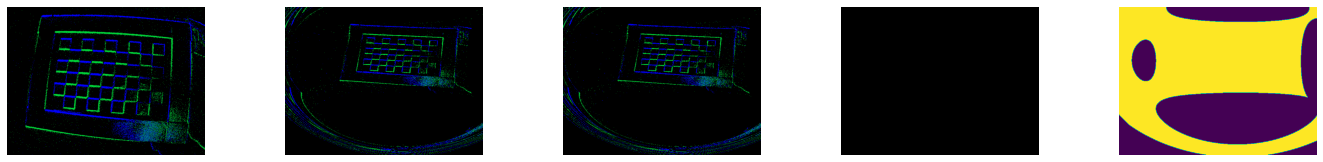

1


<Figure size 432x288 with 0 Axes>

In [1]:

%matplotlib inline

import xml.etree.ElementTree as ET
import re
import numpy as np
import time
import cv2 as cv
import glob
import matplotlib.image as mpimg
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import LinearSegmentedColormap


my_gradient = 'nipy_spectral'

'''
For camera N: load params from cam<N>.xml and use distorted_<N>.png to create distortion maps
The distortion maps are saved in mapx_cam<N>.csv and mapy_cam<N>.csv
Two undistortion procedures are performed (to validate the maps): with and without 'cv'
'''

def load_params(filename):

    tree = ET.parse(filename)
    root = tree.getroot()

    w = int(root[0][2].text) # number of columns in camera sensor
    h = int(root[0][3].text) # number of rows in camera sensor

    # Regular expression to get values out of *.xml
    rescinot = re.compile('[-+]?[\d]+\.?[\d]*[Ee](?:[-+]?[\d]+)?|[\d]')

    # Get Camera Matrix 
    cam_m = np.array(re.findall(rescinot, root[0][0][3].text))

    # Get Distortion Coefficients
    d_coeff = np.array(re.findall(rescinot, root[0][1][3].text))

    # Refactoring matrices and coefficients
    cam_m = cam_m.astype(np.float64).reshape((3,3))
    d_coeff = d_coeff.astype(np.float64)
    
    return w, h, cam_m, d_coeff

    
def get_distortion_maps(camera_id, z):
     
    # Reading parameters from *.xml
    w, h, cam_m, d_coeff = load_params("calibration/cam" + str(camera_id) + ".xml")
    print("Loading %s" %("calibration/cam" + str(camera_id) + ".xml"))
        
    # Undistorting stuff ...
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(cam_m, d_coeff, (h,w), z, (h,w))
    mapx, mapy = cv.initUndistortRectifyMap(cam_m, d_coeff, None, newcameramtx, (w,h), 5)
    
    
    np.savetxt("mapx_cam" + str(camera_id) + ".csv", mapx, delimiter=",")
    np.savetxt("mapy_cam" + str(camera_id) + ".csv", mapy, delimiter=",")
    
    return mapx, mapy

def create_empty_lut(w, h):
    
    lut = {}    
    for i in range(w): #640
        for j in range(h): #480                               
                idx = h*i+j
                lut[idx] = []
    return lut

def undistort_pt_by_pt(distorted, mapx, mapy):
    
    x = distorted.shape[1]
    y = distorted.shape[0]
    
    occurrences = np.zeros((y,x), dtype=int)
    undistorted = np.zeros(distorted.shape, dtype=int)
    
    lut = create_empty_lut(x, y)   
    for i in range(x): #640
        for j in range(y): #480  
            old_x = int(mapx[j, i]) # WARNING: might be [j, i] ...
            old_y = int(mapy[j, i]) # WARNING: might be [j, i] ...
            if ((old_x>=0) and (old_x<x)) and ((old_y>=0) and (old_y<y)):
                undistorted[j, i, :] = distorted[old_y, old_x, :]
                occurrences[old_y, old_x] += 1
                             
                idx = y*old_x+old_y
                lut[idx].append([i,j])
    
    return undistorted, occurrences, lut

def undistort_with_lut(distorted, lut):
    
    x = distorted.shape[1]
    y = distorted.shape[0]
    
    activity = np.zeros((y,x), dtype=int)
    undistorted = np.zeros(distorted.shape, dtype=int)
    for i in range(x): #640
        for j in range(y): #480  
            idx = y*i+j
            for k in range(len(lut[idx])):
                undistorted[lut[idx][k][1], lut[idx][k][0], :] = distorted[j, i, :]
                activity[lut[idx][k][1], lut[idx][k][0]] += 1
            
            
    return undistorted, activity

    
if __name__ == "__main__":
    
    
    camera_id = 1
    z = 1
    
    print("\n\n\nFor Camera #%d with z=%1.2f" %(camera_id, z))
    img_name = "distorted_" + str(camera_id) + ".png"
    
    # Which image?
    distorted = cv.imread(img_name)    

    # Get distortion maps
    mapx, mapy = get_distortion_maps(camera_id, z)

    # Get undistorted image (using distortion maps)
    start = time.time()
    undistorted_map, occurrences, lut = undistort_pt_by_pt(distorted, mapx, mapy)
    stop = time.time()
    elapsed = stop - start
    print("undistort_pt_by_pt took: " + str(int(1000*elapsed)) + " ms.")
    
    # Get undistorted image (using lut)
    start = time.time()
    undistorted_lut, activity = undistort_with_lut(distorted, lut)
    stop = time.time()
    elapsed = stop - start
    print("undistort_with_lut took: " + str(int(1000*elapsed)) + " ms.")

    
    fig, axs = plt.subplots(1,5, figsize=(20,10))
    fig.tight_layout(pad=5.0)
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[3].axis('off')
    axs[4].axis('off')
    axs[0].imshow(distorted)
    axs[1].imshow(undistorted_map)  
    axs[2].imshow(undistorted_lut)  
    axs[3].imshow(undistorted_map-undistorted_lut)
    axs[4].imshow(activity)
    plt.pause(1)
    plt.clf() 

    print(np.max(activity))
    